In [1]:
%matplotlib inline
import re as re
import pandas as pd
import numpy as np
import seaborn as sbn
from scipy.stats import norm
import matplotlib.pyplot as plt
import warnings as warnings
warnings.filterwarnings('ignore')

sbn.set_style('white')
sbn.set_context('talk')

np.random.seed(12345678)

> Note: these are my personal opinions and I'm sure that lots of people would disagree with my assessment of available software packages.

We have been working on getting under the hood of Metropolis-Hastings and Monte Carlo Markov Chain.  But there are some very accessible Metropolis Markov Chain software packages out there.  These are my personal views on what is available:

1. Stata (`bayesianmh`)- just available in Stata 14.  To be honest, I have never heard of anyone using Stata for Bayesian Sampling Methods although I haven't really looked.
2. Matlab.  There are numerous user and Matlab written routines.  For example, there is a version of `emcee` that is implemented there (more on this later in the course).  Matlab is for people who want to possibly tweak their own sampler code and who need the fastest possible computation.
2. SAS.  A decent set of packages, not used very much in the social sciences (maybe in the medical sciences??), but is well suited for big data.
3. R.  For a long time R was the de-facto standard and probably still is, with packages like R-stan which interfaces the `STAN` C Library.  Also `Jags`, `Rbugs` and `Open BUGS` have been around for a long time. I almost elected to teach this course in R. 
4. Python. The libraries aren't as rich as R, but you might view Python as sitting between Matlab and R.  Maybe (in my view probably) also easier to code your own samplers than R as I really prefer python syntax to R.  Python is the used a lot in many fields including physics and is strong in the big-data arena, more so than any of the other packages mentioned above. The major players on python are:
    * PyMC and PyMC3 (in beta)
    * PyStan
    * EMCEE
    
Today, we are going to focus on PyMC3, which is a very easy to use package now that we have a solid understanding of how posteriors are constructed.    

We will start with our very simple one parameter model and then move to slightly more complicated settings:

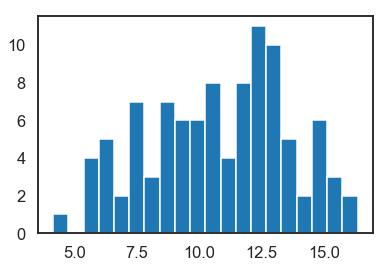

In [2]:
sigma = 3 # Note this is the std of our data
data = norm(10,sigma).rvs(100)
mu_prior = 8
sigma_prior = 1.5  # Note this is our prior on the std of mu

plt.hist(data,bins=20)
plt.show()

# PyMC3

Let's use PyMC3 to model this:

In [3]:
import pymc3 as pm3

This is the model statement describing priors and the likelihood.  Here, `mu` is defined as a stochastic variable (we want a chain of sampled values for this variable) and we provide a prior distribution and hyper-parameters for it.  The likelihood function is chosen to be Normal, with one parameter to be estimated (`mu`), and we use known $\sigma$ (denoted as `sigma`).  Our "dependent variable" is given by `observed=data`, where `data` is generated above and shown in the histogram.  In more formal terms, the code below sets up a `basic_model` having the following form:

\begin{align}
Prob(\mu|\sigma,\mathbf{data}) \propto& Prob(\mathbf{data}|\mu,\sigma) \times Prob(\mu | \mu^0_\mu, \sigma^0_\mu) \\
Prob(\mu|\sigma,\mathbf{data}) \propto& \phi \left( \frac{\mathbf{data} - \mu}{\sigma} \right ) \times \phi \left(\frac{\mu - \mu^0_\mu}{\sigma^0_\mu} \right ) \\
Prob(\mu|\sigma,\mathbf{data}) \propto& \phi \left( \frac{\mathbf{data} - \mu}{3} \right ) \times \phi \left(\frac{\mu - 8}{1.5} \right ) 
\end{align}
where $\phi(.)$ is the standard normal pdf. 

In [4]:
basic_model = pm3.Model()

with basic_model:

    # Priors for unknown model parameters
    mu = pm3.Normal('Mean of Data',mu_prior,sigma_prior)
    
    # Likelihood (sampling distribution) of observations
    data_in = pm3.Normal('Y_obs', mu=mu, sd=sigma, observed=data)

This defines how the chain will be constructed.  We will set startvals at MAP and use a Metropolis step method (which is Random Walk MH that we have studied).

In [5]:
chain_length = 10000 

with basic_model:
    # obtain starting values via MAP
    startvals = pm3.find_MAP(model=basic_model)
    print(startvals)
    # instantiate sampler
    step = pm3.Metropolis() 

    # draw 5000 posterior samples
    trace = pm3.sample(chain_length, step=step, start=startvals) 

logp = -290.67, ||grad|| = 31.153: 100%|██████████| 4/4 [00:00<00:00, 1555.17it/s]


{'Mean of Data': array(10.69594596)}


Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [Mean of Data]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:04<00:00, 9224.18draws/s]
The number of effective samples is smaller than 25% for some parameters.


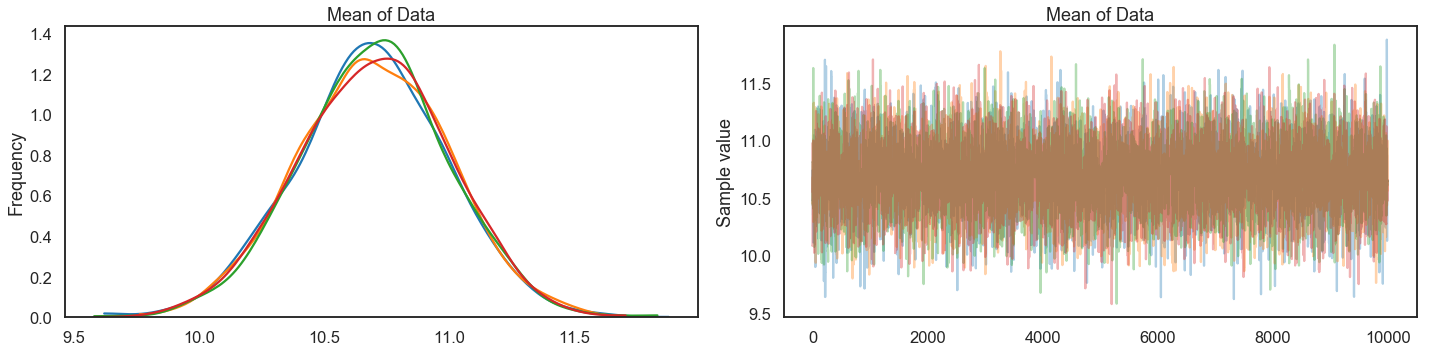

In [6]:
pm3.traceplot(trace,figsize=(20,5));

In [7]:
pm3.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
Mean of Data,10.698323,0.298304,0.003388,10.127138,11.290343,8491.809956,1.00013


## Understanding the PyMC3 Results Object

All the results are contained in the `trace` variable.  This is a pymc3 results object. It contains some information that we might want to extract at times.  Varnames tells us all the variable names setup in our model.

In [8]:
trace.varnames

['Mean of Data']

With the variable names, we can extract chain values for each variable:

In [9]:
trace['Mean of Data']

array([10.47837212, 10.47837212, 10.47837212, ..., 10.65640358,
       10.65640358, 10.47800609])

So for each variable, we have an array of values, which is our chain.

## Diagnostics

### Autocorrelation Plots

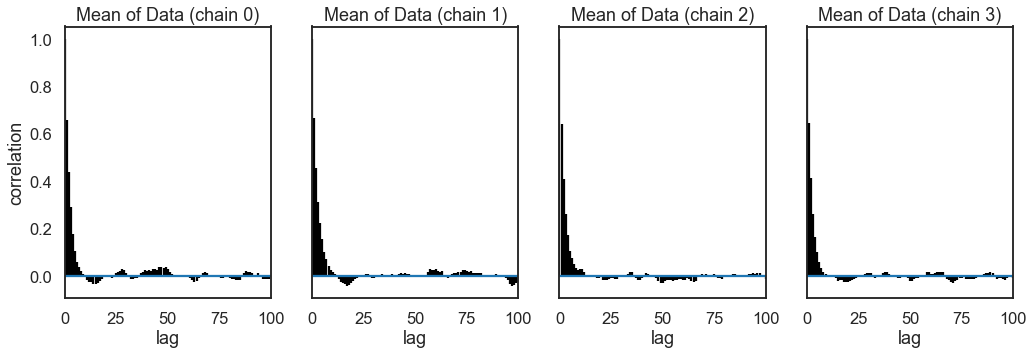

In [10]:
pm3.plots.autocorrplot(trace,figsize=(17,5));

### Acceptance Rate

In [11]:
accept = np.sum(trace['Mean of Data'][1:] != trace['Mean of Data'][:-1])
print("Acceptance Rate: ", accept/trace['Mean of Data'].shape[0])

Acceptance Rate:  0.3393


### Geweke Score

In [12]:
score=pm3.geweke(trace, first=0.1, last=0.5, intervals=20)
score

{0: {'Mean of Data': array([[ 0.00000000e+00,  3.98089881e-02],
         [ 2.63000000e+02,  3.62035946e-02],
         [ 5.26000000e+02, -2.17552281e-02],
         [ 7.89000000e+02, -4.24670150e-02],
         [ 1.05200000e+03, -3.11835563e-02],
         [ 1.31500000e+03,  1.68953273e-02],
         [ 1.57800000e+03, -4.88126007e-02],
         [ 1.84100000e+03, -3.36627389e-02],
         [ 2.10400000e+03, -1.12498869e-01],
         [ 2.36700000e+03, -9.30590373e-02],
         [ 2.63000000e+03, -5.75132684e-02],
         [ 2.89300000e+03, -7.35140470e-02],
         [ 3.15600000e+03, -4.69262730e-02],
         [ 3.41900000e+03,  2.63093107e-02],
         [ 3.68200000e+03,  7.54162558e-02],
         [ 3.94500000e+03,  1.94482040e-02],
         [ 4.20800000e+03, -1.93971697e-02],
         [ 4.47100000e+03, -4.05472731e-02],
         [ 4.73400000e+03,  7.72650011e-02],
         [ 4.99700000e+03,  1.40478948e-01]])},
 1: {'Mean of Data': array([[ 0.00000000e+00,  5.70312640e-04],
         [ 2.6

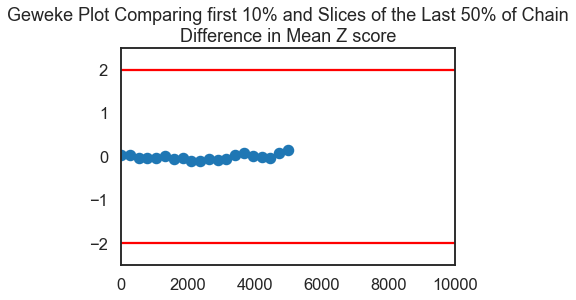

In [13]:
score=pm3.geweke(trace, first=0.1, last=0.5, intervals=20)
plt.scatter(score[0]['Mean of Data'][:,0],score[0]['Mean of Data'][:,1], marker = 'o', s=100)
plt.axhline(-1.98, c='r')
plt.axhline(1.98, c='r')
plt.ylim(-2.5,2.5)
plt.xlim(0-10,.5*trace['Mean of Data'].shape[0]/2+10)
plt.title('Geweke Plot Comparing first 10% and Slices of the Last 50% of Chain\nDifference in Mean Z score')
plt.show()

# Gelmen-Rubin 

For GR, we need multiple chains in order to test if each of the chains collapse to the limiting distribution which is our posterior.  PyMC3 makes it very easy to generate these.

In [14]:
chain_length = 100000 

with basic_model:
    # obtain starting values via MAP
    startvals = pm3.find_MAP(model=basic_model)
    print(startvals)
    # instantiate sampler
    step = pm3.Metropolis() 

    # draw 5000 posterior samples
    trace = pm3.sample(chain_length, step=step, start=startvals, njobs=2)

logp = -290.67, ||grad|| = 31.153: 100%|██████████| 4/4 [00:00<00:00, 2157.56it/s]


{'Mean of Data': array(10.69594596)}


Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [Mean of Data]
Sampling 2 chains: 100%|██████████| 201000/201000 [00:24<00:00, 8200.02draws/s]
The number of effective samples is smaller than 25% for some parameters.


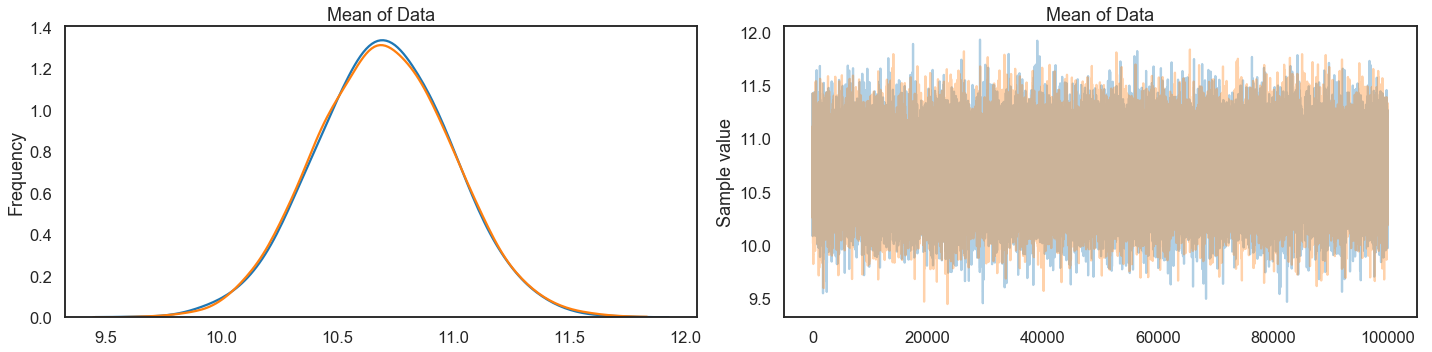

In [15]:
pm3.traceplot(trace,figsize=(20,5));

In [16]:
pm3.gelman_rubin(trace)

{'Mean of Data': 0.9999951110055701}

Based on Gelman-Rubin and Geweke, we can be confident we have a chain that has converged to the limiting distribution (although perhaps for Gelman-Rubin, we'd want to try different starting values rather than MAP).

# In class excercise

Team up and modify the code below to estimate sigma as well as the mean: 

In [17]:
basic_model = pm3.Model()

with basic_model:

    # Priors for unknown model parameters
    mu = pm3.Normal('Mean of Data',mu_prior,sigma_prior)
    
    # Likelihood (sampling distribution) of observations
    data_in = pm3.Normal('Y_obs', mu=mu, sd=sigma, observed=data)

In [18]:
chain_length = 10000 

with basic_model:
    # obtain starting values via MAP
    startvals = pm3.find_MAP(model=basic_model)
    print(startvals)
    # instantiate sampler
    step = pm3.Metropolis() 

    # draw 5000 posterior samples
    trace = pm3.sample(chain_length, step=step, start=startvals) 

logp = -290.67, ||grad|| = 31.153: 100%|██████████| 4/4 [00:00<00:00, 1577.25it/s]
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [Mean of Data]


{'Mean of Data': array(10.69594596)}


Sampling 4 chains: 100%|██████████| 42000/42000 [00:05<00:00, 7569.48draws/s]
The number of effective samples is smaller than 25% for some parameters.


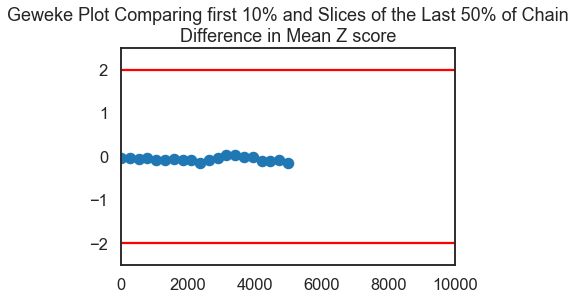

In [19]:
score=pm3.geweke(trace, first=0.1, last=0.5, intervals=20)
plt.scatter(score[0]['Mean of Data'][:,0],score[0]['Mean of Data'][:,1], marker = 'o', s=100)
plt.axhline(-1.98, c='r')
plt.axhline(1.98, c='r')
plt.ylim(-2.5,2.5)
plt.xlim(0-10,.5*trace['Mean of Data'].shape[0]/2+10)
plt.title('Geweke Plot Comparing first 10% and Slices of the Last 50% of Chain\nDifference in Mean Z score')
plt.show()